In [249]:
import numpy as np # linear algebra
import pandas as pd
import os
import json
import re, string
import sys
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import optimize

In [250]:
def init_ds(json):
    ds= {}
    keys = json.keys()
    for k in keys:
        ds[k]= []
    return ds, keys

def read_json(file):
    dataset = {}
    keys = []
    with open(file) as file_lines:
        for count, line in enumerate(file_lines):
            data = json.loads(line.strip())
            if count ==0:
                dataset, keys = init_ds(data)
            for k in keys:
                dataset[k].append(data[k])
                
        return pd.DataFrame(dataset)

In [253]:
yelp_review = read_json("/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json")
# yelp_review["date"] = pd.to_datetime(yelp_review["date"], format = "%Y-%m-%d")

In [254]:
def tokenize(s):
    """Convert string to lowercase and split into words (ignoring
    punctuation), returning list of words.
    """
    word_list = re.findall(r'\w+', s.lower())
    filtered_words = [word for word in word_list]
    return filtered_words


def count_ngrams(lines, min_length=1, max_length=1):
    lengths = range(min_length, max_length + 1)
    ngrams = {length: collections.Counter() for length in lengths}
    queue = collections.deque(maxlen=max_length)

    # Helper function to add n-grams at start of current queue to dict
    def add_queue():
        current = tuple(queue)
        for length in lengths:
            if len(current) >= length:
                ngrams[length][current[:length]] += 1

    # Loop through all lines and words and add n-grams to dict
    for line in lines:
        for word in tokenize(line):
            queue.append(word)
            if len(queue) >= max_length:
                add_queue()

    while len(queue) > min_length:
        queue.popleft()
        add_queue()

    return ngrams

## Clustering

In [255]:
doc = yelp_review.text[0:800]
review_length = []
for line in doc:
    words = tokenize(line)
#     print(words)
    review_length.append(len(words))
print(len(review_length))

800


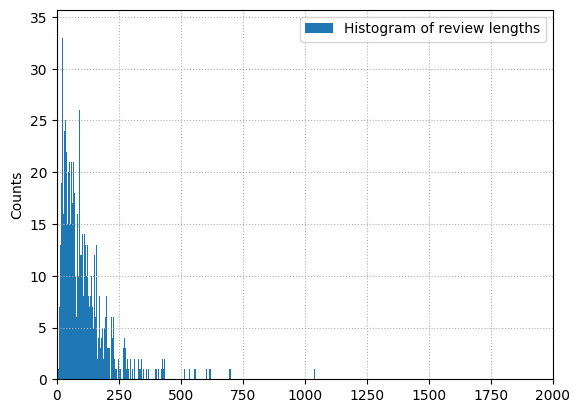

In [256]:
bins = 300

fig1, ax1 = plt.subplots()
#ax1.set_axisbelow(True)
ax1.set_xlim(0,2000)
(counts1,edges1, patches1) = plt.hist(review_length, bins, label="Histogram of review lengths")
plt.ylabel("Counts")
plt.legend(loc = 'upper right')
plt.grid(linestyle=':')
plt.show()

# plt.hist(review_length, bins = 200)
# plt.savefig("02.review.length.pdf", format="pdf", bbox_inches="tight") 

In [257]:
def GaussianFit(x, amplitude, mu, sig):
    return amplitude *(1/(sig*np.sqrt(2*np.pi)))*np.exp((-1/2)*(x-mu)**2/sig**2)

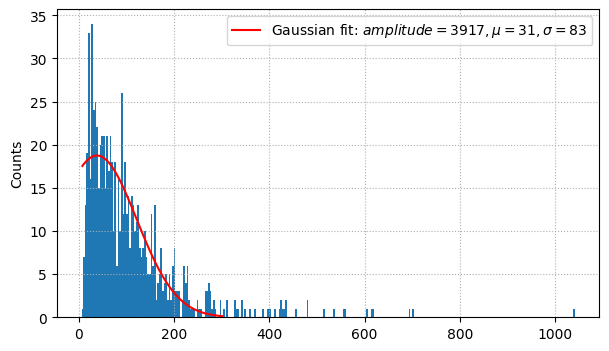

In [258]:
binscenters = np.array([0.5 * (edges1[i] + edges1[i+1])  for i in range(len(edges1)-1)])
# print(binscenters)

x1 = []
y1 = []
for i in range(len(edges1)):
    if (edges1[i] > 0) and (edges1[i] < 300):
        y1.append(counts1[i])
        x1.append(binscenters[i])

popt, pcov = curve_fit(GaussianFit, x1-x1[0],y1)
fig1, ax1 = plt.subplots(1,1,figsize=(7,4))

(counts1,edges1, patches1) = plt.hist(review_length, bins)

# fig2, ax2 = plt.subplots(1,1,figsize=(7,4))

plt.plot(x1, GaussianFit(x1-x1[0], *popt), color='red',label= r'Gaussian fit: $amplitude=%5.0f, \mu=%5.0f, \sigma=%5.0f$' % tuple(popt))

plt.ylabel("Counts")
plt.legend(fontsize=10, loc='upper right')
plt.grid(linestyle=':')
plt.savefig("02.review.length.pdf", format="pdf", bbox_inches="tight") 
plt.show()

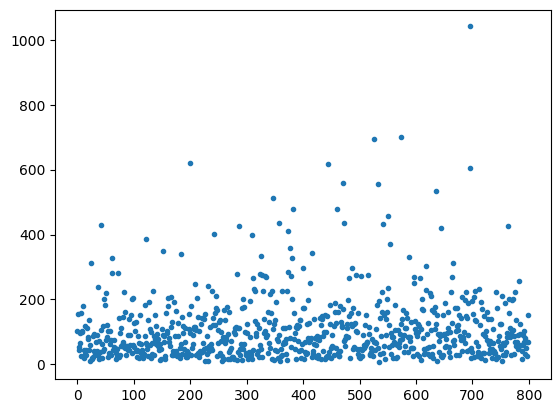

In [259]:
x = np.arange(len(review_length))
y = review_length
# plt.scatter(x, y)
plt.plot(x,y, ".")

In [260]:
points = np.column_stack((x,y))

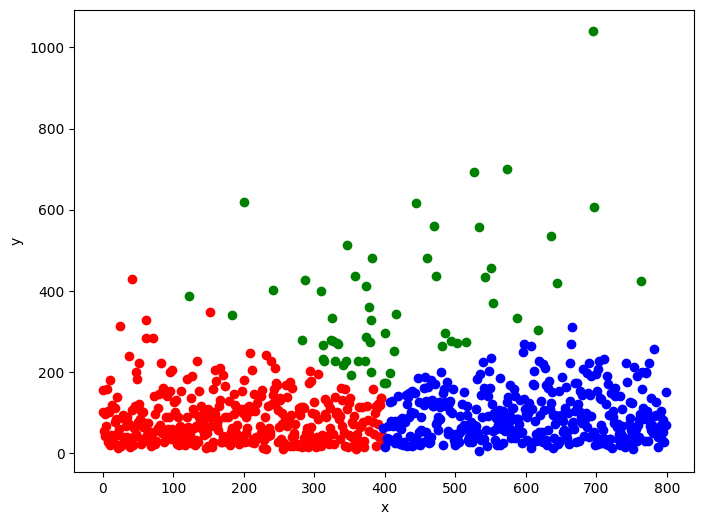

In [261]:
# Choose cluster centers randomly
centers = np.random.rand(3, 2) * 1000

# Repeat until convergence
while True:
    # Assign points to clusters based on minimum distance
    clusters = [[] for _ in range(3)]
    for point in points:
        distances = np.linalg.norm(centers - point, axis=1)
        cluster_idx = np.argmin(distances)
        clusters[cluster_idx].append(point)

    # Update cluster centers
    new_centers = np.zeros_like(centers)
    for i, cluster in enumerate(clusters):
        if cluster:
            new_centers[i] = np.mean(cluster, axis=0)
        else:
            new_centers[i] = centers[i]
    
    # Check for convergence
    if np.allclose(centers, new_centers):
        break
    
    centers = new_centers

# Plot the clusters
plt.figure(figsize=(8, 6))
colors = ['r', 'g', 'b']
for i, cluster in enumerate(clusters):
    color = colors[i]
    xs = [p[0] for p in cluster]
    ys = [p[1] for p in cluster]
    plt.scatter(xs, ys, c=color)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [262]:
def distance(p1,p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

distance(points[0], points[2])

47.042533945356304

In [263]:
distance_matrix = np.zeros(shape = (len(x),len(x)))

for i in range(len(x)):
    for j in range(len(x)):
        distance_matrix[i][j] = distance(points[i], points[j])
        
print(distance_matrix)

[[  0.          54.00925847  47.04253395 ... 797.64215034 799.5029706
  799.68118647]
 [ 54.00925847   0.         101.00495037 ... 800.63225016 797.01568366
  802.72847215]
 [ 47.04253395 101.00495037   0.         ... 795.14149684 801.76804626
  797.12295162]
 ...
 [797.64215034 800.63225016 795.14149684 ...   0.          81.0061726
    2.23606798]
 [799.5029706  797.01568366 801.76804626 ...  81.0061726    0.
   82.00609733]
 [799.68118647 802.72847215 797.12295162 ...   2.23606798  82.00609733
    0.        ]]


In [264]:
while len(clusters) > 3:
    # Find the pair of clusters with the smallest distance
    min_distance = np.inf
    merge_indices = (0, 0)
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            dist = np.min(distance_matrix[i][j])

            # Update the minimum distance 
            if dist < min_distance:
                min_distance = dist
                merge_indices = (i, j)

    # Merge the clusters with the smallest distance
    cluster1 = clusters[merge_indices[0]]
    cluster2 = clusters[merge_indices[1]]
    merged_cluster = np.concatenate((cluster1, cluster2), axis=0)
    clusters[merge_indices[0]] = merged_cluster
    clusters.pop(merge_indices[1])

print(len(clusters))
# print(clusters)

3


In [265]:
cluster1 = np.array(clusters[0])
cluster2 = np.array(clusters[1])
cluster3 = np.array(clusters[2])

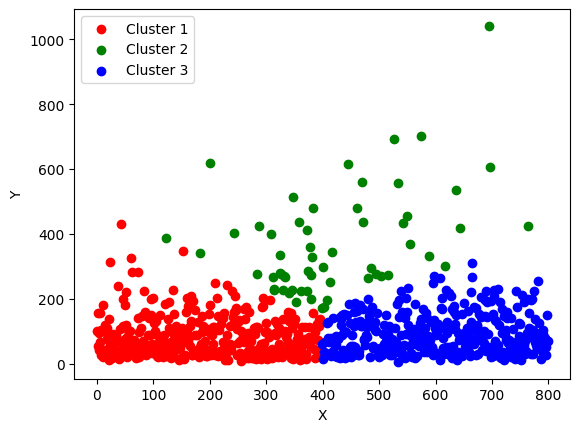

In [266]:
cluster1_x = cluster1[:, 0]
cluster1_y = cluster1[:,1]

cluster2_x = cluster2[:,0]
cluster2_y = cluster2[:,1]

cluster3_x = cluster3[:,0]
cluster3_y = cluster3[:,1]

plt.scatter(cluster1_x, cluster1_y, c='r', label='Cluster 1')
plt.scatter(cluster2_x, cluster2_y, c='g', label='Cluster 2')
plt.scatter(cluster3_x, cluster3_y, c='b', label='Cluster 3')

plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()